# Making joblib

## Preprocess + Create X and y

In [1]:
# preprocess_training_data.py

import pandas as pd
import sys
import os

# Load subject model handlers directly
sys.path.append(os.path.abspath("de_model"))
from de_handler import DEModelHandler
sys.path.append(os.path.abspath("fsd_model"))
from fsd_handler import FSDModelHandler
sys.path.append(os.path.abspath("math3_model"))
from math3_handler import Math3ModelHandler
sys.path.append(os.path.abspath("python_model"))
from python_handler import PythonModelHandler

# Load full dataset
df = pd.read_csv("../dataset/train_dataset.csv")

# Subject-level predictions
df["Predicted DE Theory"] = DEModelHandler().predict_from_model(df, "de_model.joblib", "df")["Predicted DE Theory"]
df["Predicted FSD Theory"] = FSDModelHandler().predict_from_model(df, "fsd_model.joblib", "df")["Predicted FSD Theory"]
df["Predicted Math-3 Theory"] = Math3ModelHandler().predict_from_model(df, "math3_model.joblib", "df")["Predicted Math-3 Theory"]
df["Predicted Python Theory"] = PythonModelHandler().predict_from_model(df, "python_model.joblib", "df")["Predicted Python Theory"]

# Create labels (y)
sem3_cols = ["Math-3 Theory", "DE Theory", "FSD Theory", "Python Theory"]
df["Sem 3 Percentage"] = df[sem3_cols].mean(axis=1).round(2)

df["Sem 3 Percentile"] = df["Sem 3 Percentage"].rank(pct=True) * 100

df["Sem 2 Percentage"] = df[[
    "Math-2 Theory", "Data Structures using Java Theory", "DBMS Theory",
    "Fundamental of Electronics and Electrical Theory", "Java-2 Theory"
]].mean(axis=1).round(2)

df["Sem 2 Percentile"] = df["Sem 2 Percentage"].rank(pct=True) * 100

df["Percentile Drop"] = (df["Sem 2 Percentile"] - df["Sem 3 Percentile"]).round(2)

df["Risk Flag"] = df["Percentile Drop"] > 10

y = df["Risk Flag"].astype(int)

# Feature engineering
df["Sem 1 Percentage"] = df[[
    "Math-1 Theory", "Physics Theory", "Java-1 Theory", "Software Engineering Theory"
]].mean(axis=1).round(2)


df = df.rename(columns={"Div-1": "Section-1", "Div-2": "Section-2", "Div-3": "Section-3"})
for sec in ["Section-1", "Section-2", "Section-3"]:
    df[sec] = df[sec].str[0]

df["Sem 1 Percentile"] = df["Sem 1 Percentage"].rank(pct=True) * 100


df.drop(columns=[
    "Student ID", "Mentor-1", "Mentor-2", "Mentor-3", "Roll-2", "Roll-3",
    "Math-3 Theory", "DE Theory", "DE Practical", "FSD Theory", "FSD Practical",
    "Python Theory", "Python Practical", "Communication Theory", "Law Theory",
    "Sem 3 Percentage","Sem 3 Percentile", "Percentile Drop", "Risk Flag"
], inplace=True, errors="ignore")


df["Predicted Sem 3 Percentage"] = df[[
    "Predicted Math-3 Theory", "Predicted DE Theory", "Predicted FSD Theory", "Predicted Python Theory"
]].mean(axis=1).round(2)

df["Predicted Sem 3 Percentile"] = df["Predicted Sem 3 Percentage"].rank(pct=True) * 100
df["Predicted Percentile Drop"] = (df["Sem 2 Percentile"] - df["Predicted Sem 3 Percentile"]).round(2)
df["Predicted Risk Flag"] = df["Predicted Percentile Drop"] > 10

# Save for joblib training
df.to_csv("X_for_training.csv", index=False)
y.to_csv("y_for_training.csv", index=False)


In [2]:
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from imblearn.ensemble import BalancedBaggingClassifier, EasyEnsembleClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif
import warnings
warnings.filterwarnings("ignore")

# ====== Load Preprocessed Data ======
X = pd.read_csv("X_for_training.csv")
y = pd.read_csv("y_for_training.csv").squeeze()

# One-hot encode
X = pd.get_dummies(X)

# ====== Feature Selection ======
mi_top = X.columns[np.argsort(mutual_info_classif(X, y))[-40:]].tolist()
rf_selector = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)
boruta_selector = BorutaPy(rf_selector, n_estimators='auto', random_state=42)
boruta_selector.fit(X[mi_top].values, y.values)

selected_features = [feat for feat, keep in zip(mi_top, boruta_selector.support_) if keep]
X_selected = X[selected_features]

# ====== Base Models ======
catboost = CatBoostClassifier(depth=8, learning_rate=0.05, iterations=300, verbose=0, random_state=42)
eec = EasyEnsembleClassifier(n_estimators=10, random_state=42)
bbc_lgbm = BalancedBaggingClassifier(
    estimator=LGBMClassifier(n_estimators=300, learning_rate=0.03, max_depth=6,
                             colsample_bytree=0.8, min_child_samples=20, random_state=42),
    n_estimators=10, random_state=42
)

# ====== Meta Model ======
meta_model = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# ====== Stacking Ensemble ======
stacking_model = StackingClassifier(
    estimators=[
        ("catboost", catboost),
        ("eec", eec),
        ("bbc_lgbm", bbc_lgbm)
    ],
    final_estimator=meta_model,
    stack_method='predict_proba',
    passthrough=True,
    cv=5,
    n_jobs=-1
)

# ====== Cross-Validation Threshold Tuning ======
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
thresh_range = np.linspace(0.2, 0.7, 11)
best_thresh_list = []
fold_f1s = []

print("=== 5-Fold CV Threshold Tuning ===")
for fold, (train_idx, val_idx) in enumerate(cv.split(X_selected, y), 1):
    X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    stacking_model.fit(X_train, y_train)
    y_proba = stacking_model.predict_proba(X_val)[:, 1]

    # Sweep thresholds and select best
    best_thresh = max(thresh_range, key=lambda t: f1_score(y_val, (y_proba >= t).astype(int)))
    best_thresh_list.append(best_thresh)

    # Report F1 at best threshold
    best_f1 = f1_score(y_val, (y_proba >= best_thresh).astype(int))
    fold_f1s.append(best_f1)
    print(f"Fold {fold}: Best Thresh = {best_thresh:.2f} | F1 Score = {best_f1:.4f}")

# Report average threshold and F1
final_thresh = np.mean(best_thresh_list)
mean_f1 = np.mean(fold_f1s)
print(f"\nFinal Average Threshold: {final_thresh:.3f}")
print(f"Average CV F1 Score     : {mean_f1:.4f}")

# ====== Retrain on Full Data ======
stacking_model.fit(X_selected, y)

# ====== Save Model ======
joblib.dump({
    "model": stacking_model,
    "features": selected_features,
    "threshold": final_thresh
}, "stacking_risk_model.joblib")


=== 5-Fold CV Threshold Tuning ===
Fold 1: Best Thresh = 0.45 | F1 Score = 0.4235
Fold 2: Best Thresh = 0.55 | F1 Score = 0.4918
Fold 3: Best Thresh = 0.50 | F1 Score = 0.5055
Fold 4: Best Thresh = 0.60 | F1 Score = 0.5455
Fold 5: Best Thresh = 0.40 | F1 Score = 0.4310

Final Average Threshold: 0.500
Average CV F1 Score     : 0.4795


['stacking_risk_model.joblib']

In [3]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ====== Load model and metadata ======
bundle = joblib.load("stacking_risk_model.joblib")
model = bundle["model"]
selected_features = bundle["features"]
threshold = bundle["threshold"]

# ====== Load training data ======
X = pd.read_csv("X_for_training.csv")
y = pd.read_csv("y_for_training.csv").squeeze()

# ====== Match feature space used in training ======
X = pd.get_dummies(X)
for col in selected_features:
    if col not in X.columns:
        X[col] = 0  # add missing columns as zero
X = X[selected_features]  # reorder to match training

# ====== Predict and threshold ======
y_proba = model.predict_proba(X)[:, 1]
y_pred = (y_proba >= threshold).astype(int)

# ====== Evaluation ======
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred, zero_division=0)
rec = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)

print("\n--- Evaluation on Training Data ---")
print(f"Threshold           : {threshold:.4f}")
print(f"Accuracy            : {acc:.4f}")
print(f"Precision           : {prec:.4f}")
print(f"Recall              : {rec:.4f}")   
print(f"F1 Score            : {f1:.4f}")



--- Evaluation on Training Data ---
Threshold           : 0.5000
Accuracy            : 0.6878
Precision           : 0.3611
Recall              : 0.7123
F1 Score            : 0.4793


In [4]:
print(X.columns.tolist())


['Predicted Math-3 Theory', 'Sem 2 Percentage', 'Sem 2 Percentile', 'Predicted Percentile Drop']


[LightGBM] [Info] Number of positive: 139, number of negative: 139
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 278, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

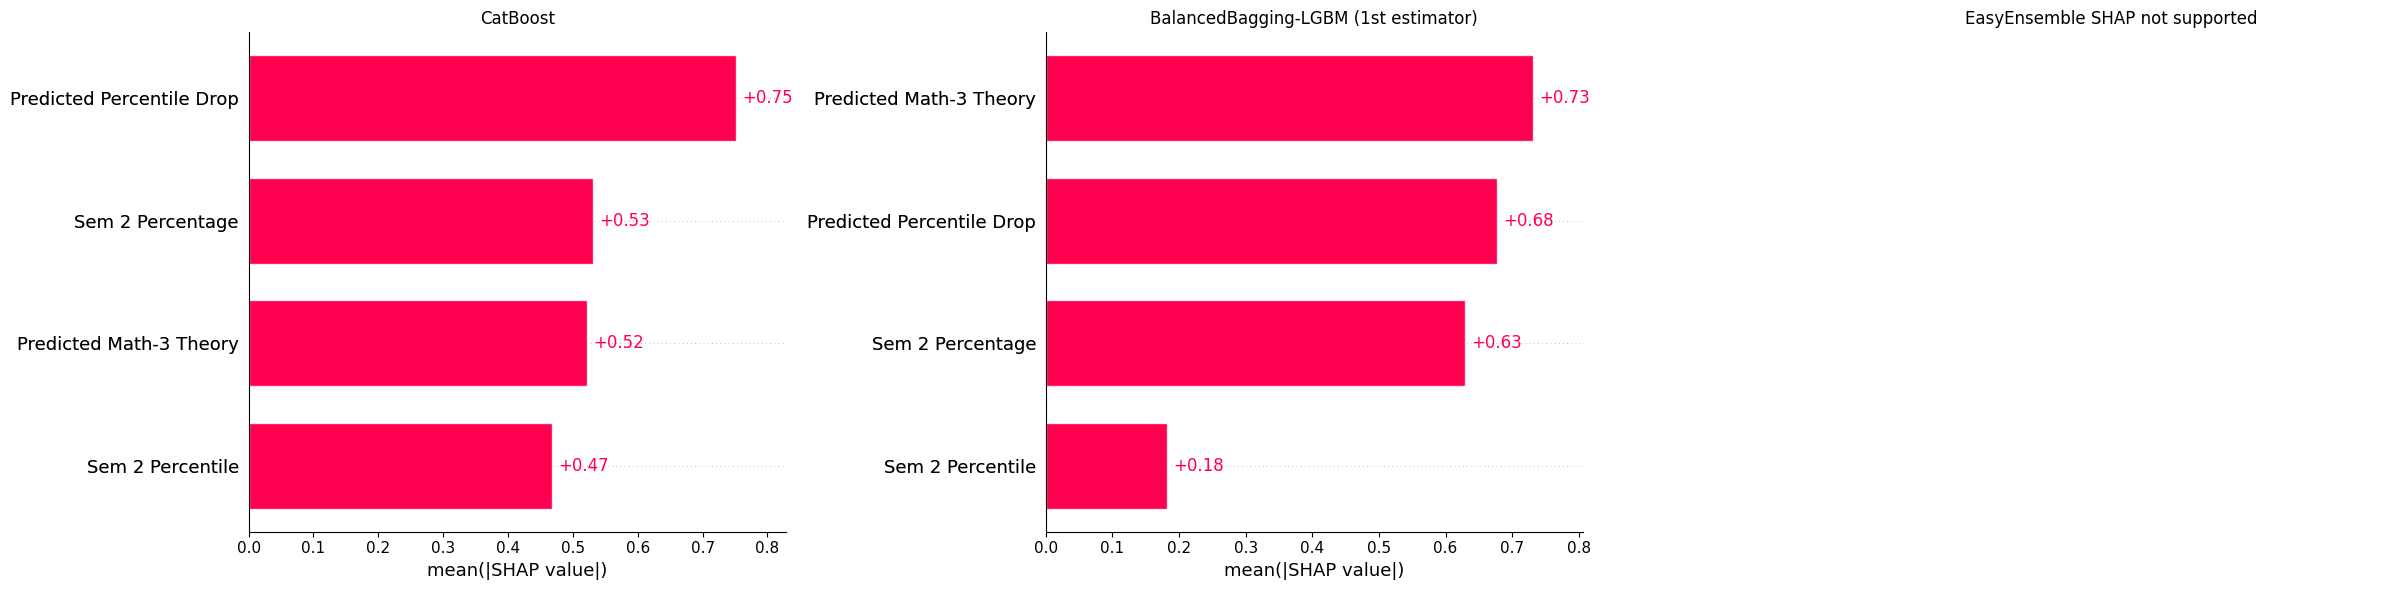

In [8]:
import shap
import matplotlib.pyplot as plt

# 1. Refit individual base models on selected data
catboost.fit(X_selected, y)
bbc_lgbm.fit(X_selected, y)
eec.fit(X_selected, y)

# 2. Extract inner models
# -- From BalancedBagging: grab LGBMClassifier from pipeline
lgbm_pipeline = bbc_lgbm.estimators_[0]  # This is a Pipeline
lgbm_model = lgbm_pipeline.named_steps['classifier']

# -- From EasyEnsemble: try to extract base AdaBoost (not always SHAP-compatible)
eec_model = eec.estimators_[0]

# 3. Create SHAP explainers
catboost_explainer = shap.Explainer(catboost)
lgbm_explainer = shap.Explainer(lgbm_model)

# Handle EasyEnsemble SHAP with fallback
try:
    eec_explainer = shap.Explainer(eec_model)
    eec_shap_values = eec_explainer(X_selected)
except:
    eec_explainer = None
    eec_shap_values = None

# Compute SHAP values
catboost_shap = catboost_explainer(X_selected)
lgbm_shap = lgbm_explainer(X_selected)

# 4. Plot SHAP bar plots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# CatBoost
shap.plots.bar(catboost_shap, max_display=10, show=False, ax=axes[0])
axes[0].set_title("CatBoost")

# LGBM
shap.plots.bar(lgbm_shap, max_display=10, show=False, ax=axes[1])
axes[1].set_title("BalancedBagging-LGBM (1st estimator)")

# EasyEnsemble
if eec_shap_values is not None:
    shap.plots.bar(eec_shap_values, max_display=10, show=False, ax=axes[2])
    axes[2].set_title("EasyEnsemble-AdaBoost (1st estimator)")
else:
    axes[2].axis("off")
    axes[2].set_title("EasyEnsemble SHAP not supported")

plt.tight_layout()
plt.savefig("shap_comparison_base_models.png", dpi=300)
plt.show()
